# Standard Bank Tech Impact Challenge: Animal classification

The objective of this challenge is to create a machine learning model to accurately predict the likelihood that an image contains a zebra, as opposed to an elephant. While this may be an easy task for humans, elephants, and zebras, your computer will find it a bit more difficult.

The total dataset contains 13,999 images of zebras and elephants, sampled from the Snapshot Serengeti collection of more than 6 million animals.

Your task is to predict whether a given image contains a zebra or elephant. For each unique image ID in the test set you should estimate the likelihood that the image contains a zebra or elephant, with an estimated probability value between 0 and 1. A value of 1 represents a zebra and 0 represents an elephant. These images do not contain both simultaneously. It is therefore only a binary classification task.

# The dataset
You are given 13,999 photos each with a unique identifier. The data is given in jpeg format. Each photo has already been resized to 330x330 pixels.

<br>

### The dataset is structured as follows:
 - ID 0 - 6,999 are all elephants.
 - ID 7,000 - 13,999 are zebras.
 
<br>

### Training set (size: 10,000):
 - ID 0 - 5,000 as well as 
 - ID 7,000 - 12,000

### Validation set (size: 2,000):
 - ID 5,000 - 5,999 as well as 
 - ID 12,000 - 12,999

### Test set (size: 2,000):
 - ID 6,000 - 6,999 as well as 
 - ID 13,000 - 13,999

<br>
The data has already been divided into the respective folders. You must write code to load the data in accordingly.


# Marking Criteria

There are multiple ways one can tackle the problem. It is up to you to decide and motivate your decisions. You are not limited to using any specific methods or models.

Motivate all of your steps taken in completing the task at hand, this includes but is not limited to:
- Exploring the data
- Data augmentation
- Preprocessing the data
- Choosing the right machine learning model(s)
- Tuning the model(s)
- Performance assessment of the model(s)

Make sure to add your thoughts and motivations behind your decision making as well as the outcome thereof in markdown cells.

**Your commentary will be more valuable than the performance of the model itself.**

Remeber to label all graphs and keep your notebook neat.

# Make sure to include an Accuracy score of you final model on the test set.
You may choose any other additional criteria you want to evaluate you final model on.

# Project Start:

In [117]:
# all imports
from os import listdir

import sklearn
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torchvision import transforms
from torchsummary import summary

from PIL import Image
import time

# set random seed
torch.manual_seed(420)

In [118]:
listdir('data')

['Valid', 'Test', 'Train']

In [119]:
train_path = 'data/Train/'
valid_path = 'data/Valid/'
test_path = 'data/Test/'

# Before Working

Firstly the layout of the folders had to be changed so that each of these 3 folders, contains the two folders, "elephants" and "zebras", containing the images corresponding to the folder name.  Also, through the terminal, we had to add the ".jpg" extension to all images.  We also removed a faulty image that was of other format.

## Look at directories

In [120]:
print(listdir(train_path))
print(f'[ {len(listdir("data/Train/elephants"))}      ,  {len(listdir("data/Train/zebras"))}   ]')

['elephants', 'zebras']
[ 5000      ,  4999   ]


In [121]:
print(listdir(valid_path))
print(f'[ {len(listdir("data/Valid/elephants"))}      ,  {len(listdir("data/Valid/zebras"))}   ]')

['elephants', 'zebras']
[ 1000      ,  1000   ]


In [122]:
print(listdir(test_path))
print(f'[ {len(listdir("data/Test/elephants"))}      ,  {len(listdir("data/Test/zebras"))}   ]')

['elephants', 'zebras']
[ 1000      ,  1000   ]


We can clearly see that the data is balanced and that there is no need to oversample/undersample.

## Visualize Images

In [123]:
original_IF = datasets.ImageFolder(train_path, transform=transforms.ToTensor())
original_DL = torch.utils.data.DataLoader(original_IF, batch_size=100,
                                          shuffle=True, num_workers=2)

In [124]:
# Show batches of Images
def show_images(images, nmax=16):
    fig, ax = plt.subplots(figsize=(18, 18))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid((images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
    
def show_smallbatch(dl, nmax=16):
    for images in dl:
        show_images(images[0], nmax)
        break

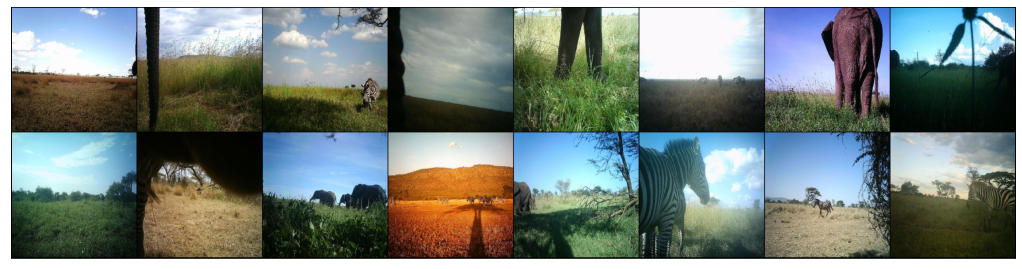

In [125]:
show_smallbatch(original_DL)

# Loading and Augmenting

In [126]:
# Normalize originals
train_transform1 = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Augmented
train_transform2 = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                      transforms.RandomHorizontalFlip(p=1)])

train_transform3 = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.ColorJitter()])

train_transform4 = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.ColorJitter(),
                                      transforms.RandomCrop(size=(330, 330))])

# Loading training set
train_data1 = datasets.ImageFolder(train_path, transform=train_transform1)
trainloader1 = torch.utils.data.DataLoader(train_data1, batch_size=100,
                                          shuffle=True, num_workers=2)
train_data2 = datasets.ImageFolder(train_path, transform=train_transform2)
trainloader2 = torch.utils.data.DataLoader(train_data2, batch_size=100,
                                          shuffle=True, num_workers=2)
train_data3 = datasets.ImageFolder(train_path, transform=train_transform3)
trainloader3 = torch.utils.data.DataLoader(train_data3, batch_size=100,
                                          shuffle=True, num_workers=2)
train_data4 = datasets.ImageFolder(train_path, transform=train_transform4)
trainloader4 = torch.utils.data.DataLoader(train_data4, batch_size=100,
                                           shuffle=True, num_workers=2)

# Adding loaders together to create a training set of 4 times the original
trainloaders = [trainloader1, trainloader2, trainloader3, trainloader4]

# Loading validation set
valid_data = datasets.ImageFolder(valid_path, transform=train_transform1)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=100,
                                          shuffle=True, num_workers=2)

# Loading test set
test_data = datasets.ImageFolder(test_path, transform=train_transform1)
testloader = torch.utils.data.DataLoader(test_data, batch_size=100,
                                          shuffle=True, num_workers=2)

# Combining original train, valid and test for later use
loaders = [trainloader1, validloader, testloader]

After a lot of testing - Augmentation used: RandomHorizontalFlip, ColorJitter, RandomCrop.  Together with the original images, we formed a training set of 40 000 images instead of just 10 000.

## Normalized Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


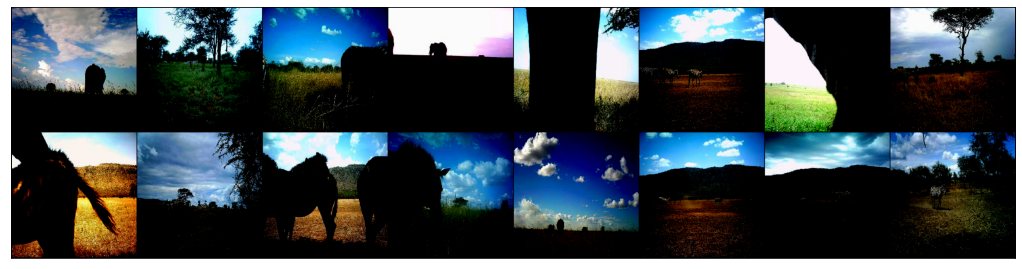

In [127]:
show_smallbatch(trainloader1)

## Random Horizontal Flip

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


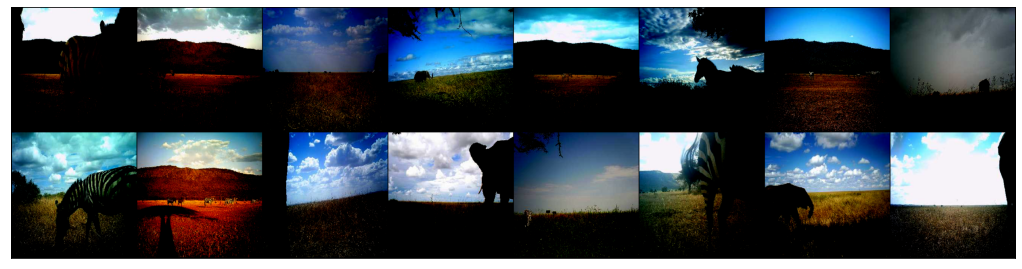

In [128]:
show_smallbatch(trainloader2)

## ColorJitter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


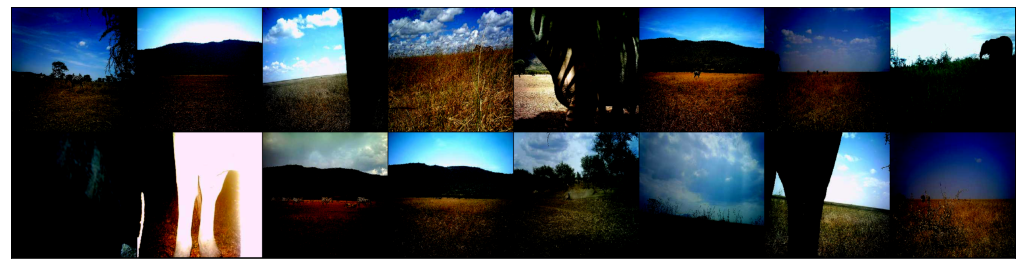

In [129]:
show_smallbatch(trainloader3)

## Random Crop

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


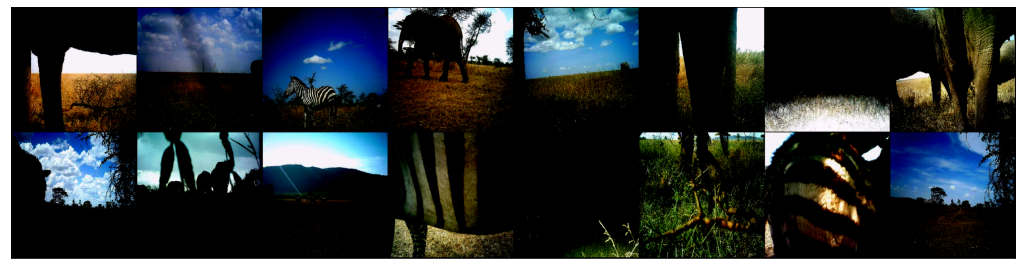

In [130]:
show_smallbatch(trainloader4)

# The actual Model!

The amount of layers and parameters chosen, were chosen according to tuning.  A lot of manual testing was done to end up with this model.

Steps taken to get to this model: 

S0. Base model

S1. Playing around with amount of layers and parameters until I got what I thought worked best.

S2. Data Augmentation. Tried doing the Augmentation on the same 10 000 and got worse.  Only when I enlarged training set with augments, it got a lot better.  And only the 3 Augments I used seemed to improve accuracy.

S3. Adding BatchNorm also increased accuracy.

S4. Tested different optimizers and criterion and Adam with learning rate (3e-4) worked best.  And also           CrossEntropyLoss seemed to work best.

S5.  Increasing epochs also worked.

S6. Then the final victory was removing Dropout

In [131]:
class Net(nn.Module):
    def __init__(self, num_classes=2):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3),
            nn.BatchNorm2d(num_features=8),  # num_features = num_channels
            nn.ReLU(inplace=True), nn.MaxPool2d(kernel_size=3),
            nn.Conv2d(8, 16, kernel_size=3),
            nn.BatchNorm2d(num_features=16),  # num_features = num_channels
            nn.ReLU(inplace=True), nn.MaxPool2d(kernel_size=3),
            nn.Conv2d(16, 32, kernel_size=3),
            nn.BatchNorm2d(num_features=32),  # num_features = num_channels
            nn.ReLU(inplace=True), nn.MaxPool2d(kernel_size=3),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(num_features=64),  # num_features = num_channels
            nn.ReLU(inplace=True), nn.MaxPool2d(kernel_size=3),)
        self.avgpool = nn.AdaptiveAvgPool2d((5, 5))
        self.classifier = nn.Sequential(
            nn.Linear(64 * 5 * 5, 256),
            nn.ReLU(inplace=True), nn.Linear(256, 128),
            nn.ReLU(inplace=True), nn.Linear(128, 64), 
            nn.ReLU(inplace=True), nn.Linear(64, 32),
            nn.ReLU(inplace=True), nn.Linear(32, num_classes),)
    
    def forward(self, x):        
        x = self.features(x)        
        x = self.avgpool(x)        
        x = x.view(x.size(0), 64 * 5 * 5)        
        x = self.classifier(x)
        return x

In [132]:
model = Net()
summary(model, (3, 330, 330))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 328, 328]             224
       BatchNorm2d-2          [-1, 8, 328, 328]              16
              ReLU-3          [-1, 8, 328, 328]               0
         MaxPool2d-4          [-1, 8, 109, 109]               0
            Conv2d-5         [-1, 16, 107, 107]           1,168
       BatchNorm2d-6         [-1, 16, 107, 107]              32
              ReLU-7         [-1, 16, 107, 107]               0
         MaxPool2d-8           [-1, 16, 35, 35]               0
            Conv2d-9           [-1, 32, 33, 33]           4,640
      BatchNorm2d-10           [-1, 32, 33, 33]              64
             ReLU-11           [-1, 32, 33, 33]               0
        MaxPool2d-12           [-1, 32, 11, 11]               0
           Conv2d-13             [-1, 64, 9, 9]          18,496
      BatchNorm2d-14             [-1, 6

## Loss and Optimizer

Coincidentally, these are the two functions and parameters we started with.  We tested other optimizers such as SGD and we also tested other hyperparameters.  After this tuning, we realised that our original ones worked the best. 

In [133]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=3e-4)


## Training

This has been commented out since we have already saved the model which will be loaded shortly.  This function gives the running loss as well as accuracy as it trains.

One epoch of training runs for just under 10 minutes.  So to run the following code with the desired 10 epochs, it about 1,5 hours to run.

In [134]:
"""
for epoch in range(10):  # loop over the dataset multiple times
    #Training
    start = time.time()
    model.train()
    running_loss = 0.0
    for l, loader in enumerate(trainloaders, 0):
        correct = 0
        total = 0
        for i, data in enumerate(loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if i % 10 == 9:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {l + 1}, {i + 1:3d}] - [loss: {running_loss / 10:.3f}] - [accuracy: {correct/total*100:.2f}]')
                running_loss = 0.0
    
    #Evaluating            
    end = time.time()
    print("\n" + str(end-start) + "\n")
    preds = []
    truths = []
    perc = []
    # since we're not training, we don't need to calculate the gradients for our outputs
    model.eval()
    for i, loader in enumerate(loaders):
        correct = 0
        total = 0
        preds.append([])
        truths.append([])
        with torch.no_grad():
            for data in loader:
                images, labels = data
                # calculate outputs by running images through the network
                outputs = model(images)
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                for item in predicted.tolist():
                    preds[i].append(item)
                for item in labels.tolist():
                    truths[i].append(item)
        perc.append(100.0 * correct / total)
        
    print(f'Epoch {epoch + 10} - [train: {perc[0]:.2f}] - [valid: {perc[1]:.2f}] - [test: {perc[2]:.2f}]')
        
print('Finished Training')
"""

'\nfor epoch in range(10):  # loop over the dataset multiple times\n    #Training\n    start = time.time()\n    model.train()\n    running_loss = 0.0\n    for l, loader in enumerate(trainloaders, 0):\n        correct = 0\n        total = 0\n        for i, data in enumerate(loader, 0):\n            # get the inputs; data is a list of [inputs, labels]\n            inputs, labels = data\n            # zero the parameter gradients\n            optimizer.zero_grad()\n            # forward + backward + optimize\n            outputs = model(inputs)\n            loss = criterion(outputs, labels)\n            loss.backward()\n            optimizer.step()\n            # print statistics\n            running_loss += loss.item()\n            \n            _, predicted = torch.max(outputs.data, 1)\n            total += labels.size(0)\n            correct += (predicted == labels).sum().item()\n            \n            if i % 10 == 9:    # print every 2000 mini-batches\n                print(f\'[{ep

## Summary of output (Accuracy)

Epoch 1 - [train: 85.68] - [valid: 84.50] - [test: 84.60]

Epoch 2 - [train: 91.31] - [valid: 89.15] - [test: 90.25]

Epoch 3 - [train: 95.19] - [valid: 93.55] - [test: 94.05]

Epoch 4 - [train: 96.84] - [valid: 95.15] - [test: 94.90]

Epoch 5 - [train: 99.29] - [valid: 97.35] - [test: 97.70]

Epoch 6 - [train: 98.38] - [valid: 96.40] - [test: 96.55]

Epoch 7 - [train: 98.98] - [valid: 96.30] - [test: 97.05]

Epoch 8 - [train: 99.46] - [valid: 97.65] - [test: 97.95]

Epoch 9 - [train: 99.70] - [valid: 97.65] - [test: 98.10]

Epoch 10 - [train: 99.65] - [valid: 97.70] - [test: 98.20]

## Loading the saved model

In [135]:
best_model = torch.load("bestmodel.pth")
if (best_model.training):
    best_model.eval()

## Accuracy

In [136]:
preds = [[],[],[]]
truths = [[],[],[]]
accuracies = []
set_names = ["Training data", "Validation data", "Test data"]
# since we're not training, we don't need to calculate the gradients for our outputs
for i, loader in enumerate(loaders, 0):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = best_model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            for item in predicted.tolist():
                preds[i].append(item)
            for item in labels.tolist():
                truths[i].append(item)

    acc = 100.0*correct/total            
    accuracies.append(acc)
    print(f'Accuracy on {set_names[i]}: {acc:.2f} %')

Accuracy on Training data: 99.65 %
Accuracy on Validation data: 97.70 %
Accuracy on Test data: 98.20 %


## Confusion Matrices

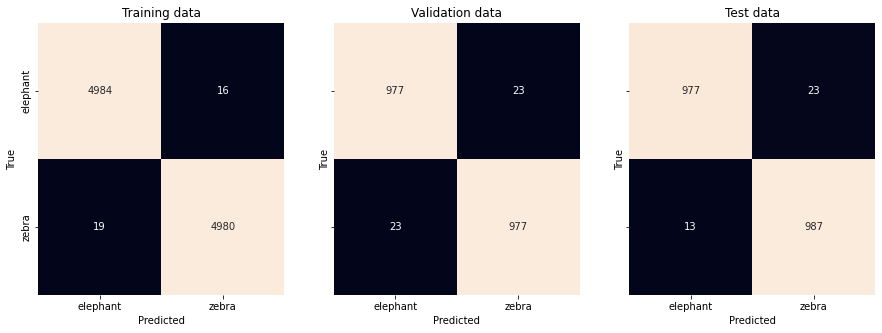

In [137]:
fig, ax = plt.subplots(1,3, figsize = (15,5), sharey = True)
labels = ['elephant', 'zebra']
for i in range(3):
    sns.heatmap(
            confusion_matrix(truths[i], preds[i]), 
            annot=True, 
            fmt='d', 
            yticklabels=labels, 
            xticklabels=labels,
            ax=ax[i],
            cbar=False
        ).set(title=set_names[i], xlabel="Predicted", ylabel="True")
plt.show()

# Conclusion

We have tuned this model as much as we possibly could with the time given.  We have also created an entirely separate model.  Through all of that, this is the best model we could come up with.  It is clear that this model performs extremely well on all three sets.  There also doesn't seem to be any overfitting, which is also great.  